In [1]:
import rpy2

%load_ext rpy2.ipython

In [2]:
%%R
library(tidyverse) 
library(zoo)
library(ggtree)
library(ape)
library(ggimage)
library(ggpubr)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


R[write to console]: 
Attaching package: ‘zoo’


R[write to console]: The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


R[write to console]: ggtree v3.10.0 For help: https://yulab-smu.top/treedata-book/

If you use the ggtree package suite in published research, please cite
the appropriate paper(s):

Guangchuang Yu, David Smith, Huachen Zhu, Yi Guan, Tommy Tsan-Yuk Lam.
ggtree: an R package for visualization and annotation of phylogenetic
trees with their covariates and other associated data. Methods in
Ecology and Evolution. 2017, 8(1):28-36. doi:10.1111/2041-210X.12628

Guangchuang Yu, Tommy Tsan-Yuk Lam, Huachen Zhu, Yi Guan. Two methods
for mapping and visualizing associated data on phylogeny using ggtree.
Molecular Biology and Evolution. 2018, 35(12):3041-3043.
doi:10.1093/molbev/msy194

Guangchuang Yu.  Data Integration, Manipulation and Visualization of
Phylogenetic Trees (1st edition). Chapman and Hall/CRC. 2022,
doi:10.1201/9781003279242

R[

In [4]:
%%R
df <- read_delim('../results/combined/all.csv', delim=',')
#neutral_pi <- read_delim('../../results/pi_in_five_percent.csv',delim = ',')
bin_df <- df %>% filter(chr != 'chrX') %>% group_by(genus,species, chr) %>% mutate(bins = ntile(start,100000)) %>% filter(chr != 'chrX') %>% filter(freq_mean > .5)
pg_namedf <- read_delim('../data/genus_phylogenetic_group_metadata.txt', delim='\t')

merged_data <- merge(bin_df, pg_namedf, by.x = "genus", by.y = "genus", all.x = TRUE)

tree <- read.tree("../data/S4_UCE_species_tree.nw.tree")

Rows: 5257244 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): chr, species, genus
dbl (13): start, end, freq_mean, freq_min, freq_max, freq_median, window_siz...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 57 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): genus, pg_name

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [ ]:
%%R

tree <- read.tree("../data/S4_UCE_species_tree.nw.tree")

In [5]:
%%R
merged_data <- merged_data %>% mutate(node = paste(genus, species, sep = '_'))

In [6]:
%%R
list_of_tips <- unique(merged_data$node)


In [7]:
%%R
diff <- setdiff(tree$tip.label, list_of_tips)

In [8]:
%%R
new_tree <- drop.tip(tree, diff)

In [9]:
%%R

reduced <- merged_data %>% group_by(node) %>%
    reframe(
        pg_name = first(pg_name))

In [10]:
%%R
reduced$pg_name <- as.factor(reduced$pg_name)
reduced

# A tibble: 194 × 2
   node                        pg_name          
   <chr>                       <fct>            
 1 Allenopithecus_nigroviridis Old_world_monkeys
 2 Allochrocebus_lhoesti       Old_world_monkeys
 3 Allochrocebus_preussi       Old_world_monkeys
 4 Allochrocebus_solatus       Old_world_monkeys
 5 Alouatta_belzebul           New_world_monkeys
 6 Alouatta_caraya             New_world_monkeys
 7 Alouatta_discolor           New_world_monkeys
 8 Alouatta_juara              New_world_monkeys
 9 Alouatta_macconnelli        New_world_monkeys
10 Alouatta_nigerrima          New_world_monkeys
# ℹ 184 more rows
# ℹ Use `print(n = ...)` to see more rows


In [11]:
%%R
new_tree1 <- left_join(new_tree, reduced, by = c('label' = 'node'))

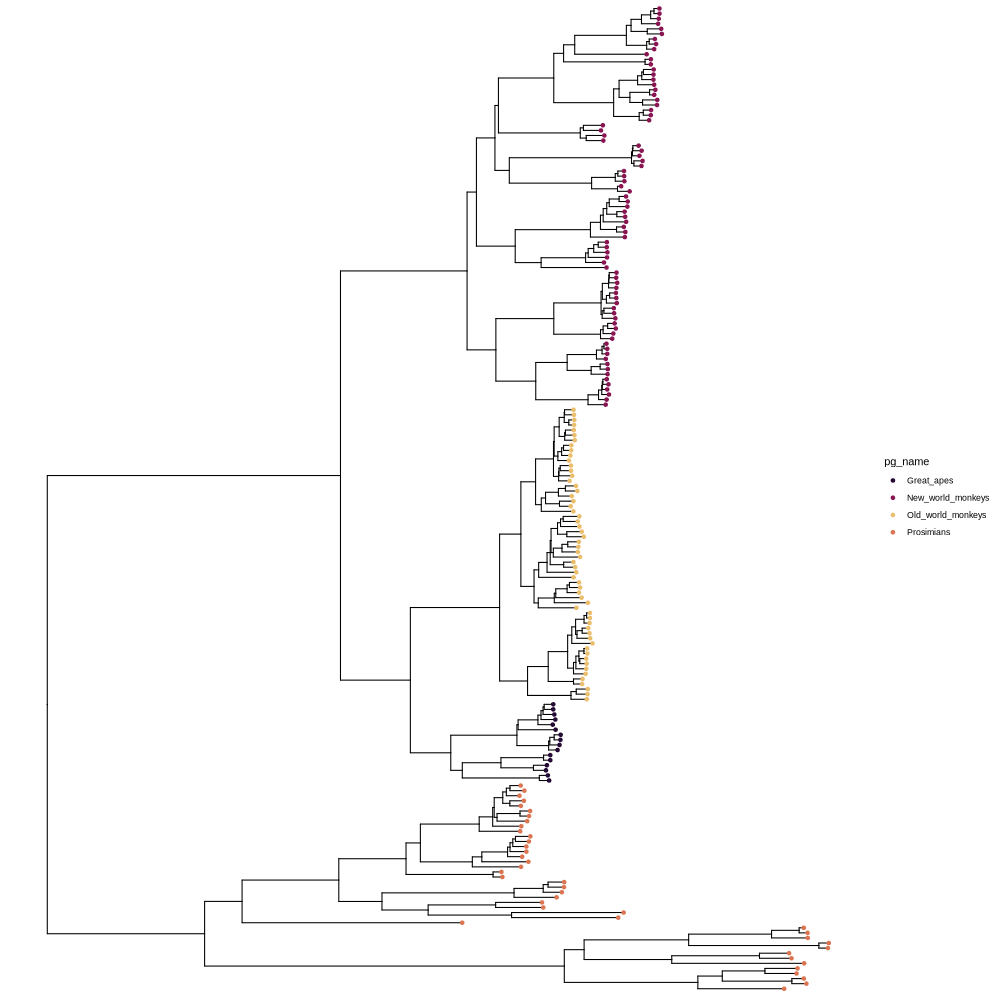

In [12]:
%%R -h 1000 -w 1000
tree_plot <- ggtree(new_tree1) +
    geom_tippoint(aes(color=pg_name), size=1.5)+
    scale_colour_manual(values = c('#240a34','#891652','#eabe6c','#db7552'))
    
    


tree_plot


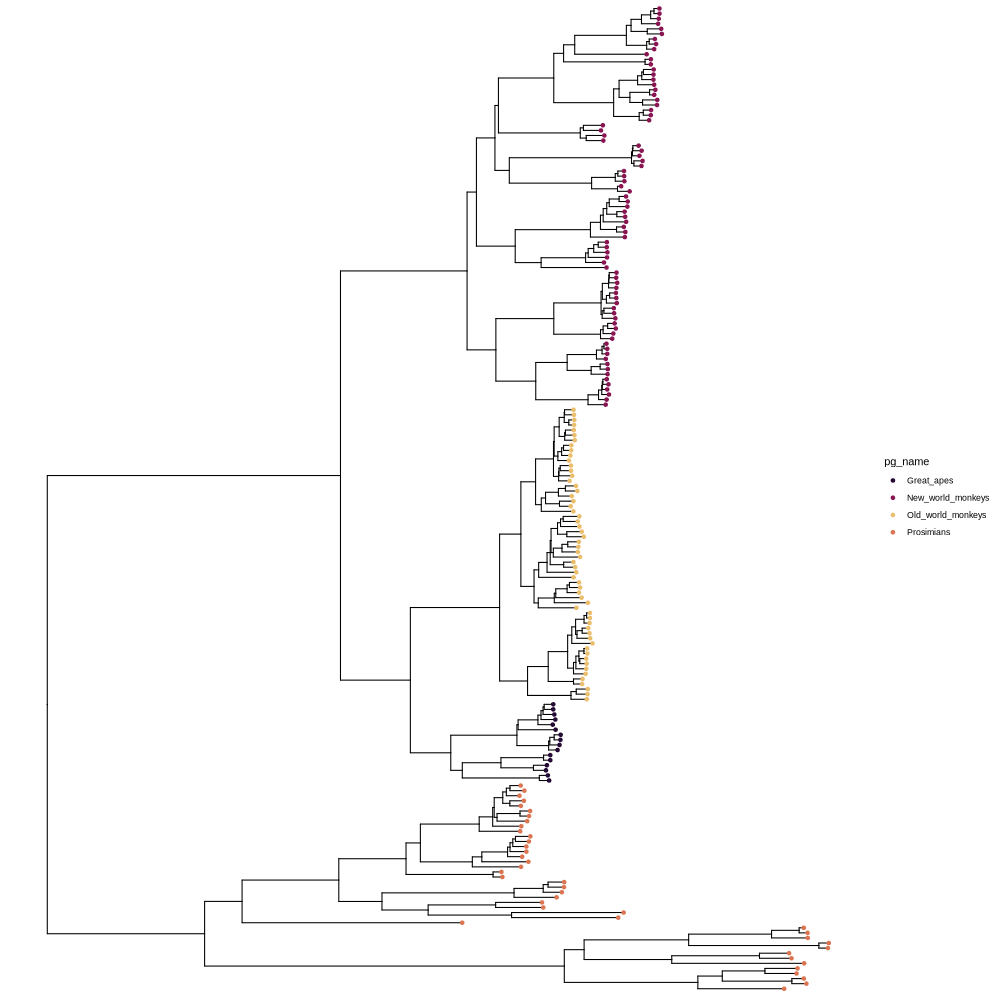

In [13]:
%%R -h 1000 -w 1000
tree_plot <- ggtree(new_tree1) +
    geom_tippoint(aes(color=pg_name), size=1.5)+
    scale_colour_manual(values = c('#240a34','#891652','#eabe6c','#db7552'))
    
    


tree_plot


In [22]:
%%R
plot_tree2 <- tree_plot  + 
    geom_strip(1, 58, barsize=4, color='#eabe6c') + #old_world
    geom_strip(59, 74, barsize=4, color='#240a34') + #Apes
    geom_strip(75, 153, barsize=4, color='#891652') + # new_world
    geom_strip(154, 194, barsize=4, color='#db7552') +
    theme(legend.position = 'none')
    #geom_tiplab(aes(image=uid, colour=pg_name), geom="phylopic", offset=2.5)

In [14]:
%%R
roll <- merged_data %>% 
    filter(freq_mean > .5) %>%
    filter(!(species %in% c('zaza','albinasus'))) %>%
    group_by(genus,species,chr, pg_name) %>% 
    reframe(
        pos = start,
        roll_pi = rollmean(PI, k = 50, fill = NA) ## 5mb rolls
    ) %>%
    na.omit()

roll$chr <- factor(roll$chr, levels = paste0("chr", 1:22))


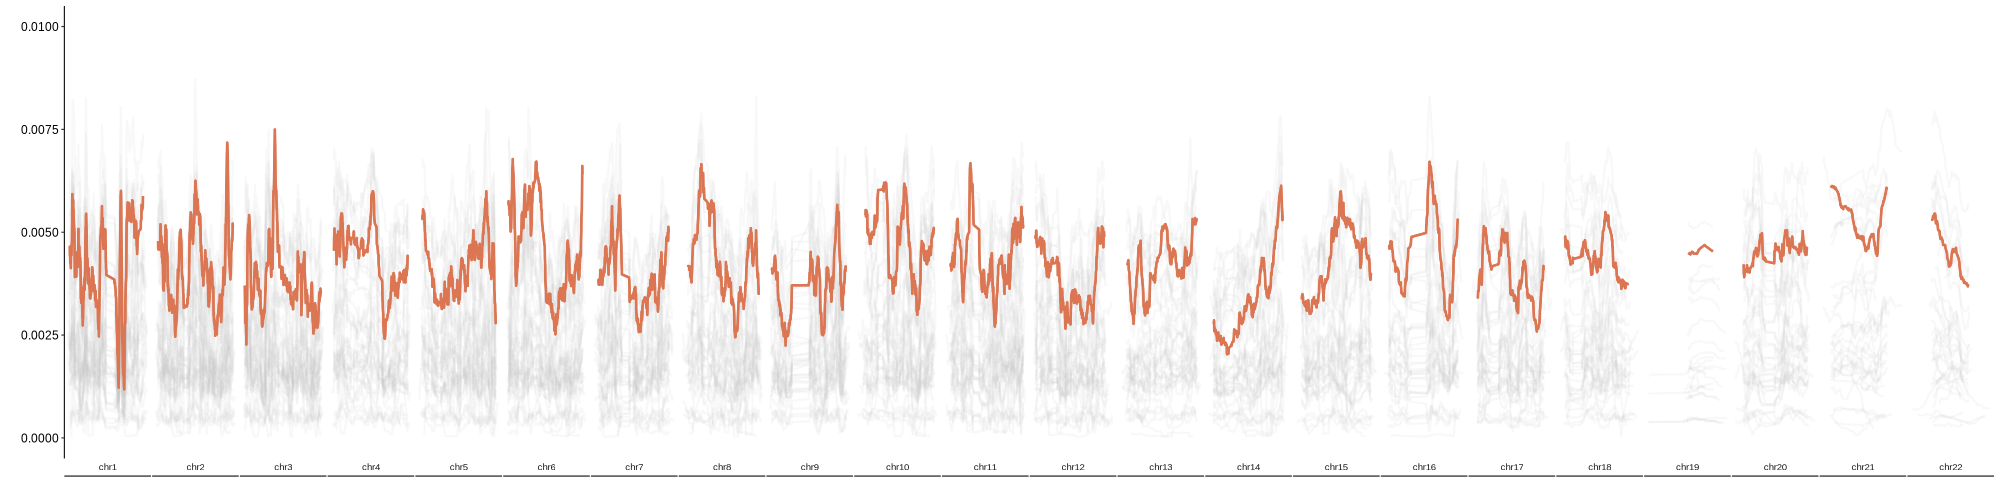

In [15]:
%%R -h 500 -w 2000

specific_species_prosimians <- roll %>% 
    filter(pg_name == 'Prosimians') %>%
    filter(!(species %in% c('zaza','albinasus'))) %>%
    filter(species == 'rufus') %>%
    group_by(genus,species)

plot_diversity_genome_prosimians <- roll %>% 
    filter(pg_name == 'Prosimians') %>%
    filter(!(species %in% c('zaza','albinasus'))) %>%
    group_by(genus,species) %>%
    ggplot(aes(x=pos,y=roll_pi, group = species, col = species == 'rufus')) +
    geom_line(aes(alpha = ifelse(species == 'rufus', 1, 0.005)), size = 1) +
    geom_line(data = specific_species_prosimians,aes(x=pos,y=roll_pi), size = 1.2) +
    ggpubr::theme_pubr(legend = 'none') +
    scale_colour_manual(values = c('grey','#db7552'))+
    facet_wrap(chr~., scales = 'free_x', nrow=1, strip.position = 'bottom')+
    xlab('')+
    ylab('') +
    ylim(0,0.01)+
    theme(axis.text.x=element_blank(), #remove x axis labels
        axis.ticks.x=element_blank(),
        panel.spacing=unit(.08,"lines"),
        strip.background = element_blank())
    
plot_diversity_genome_prosimians

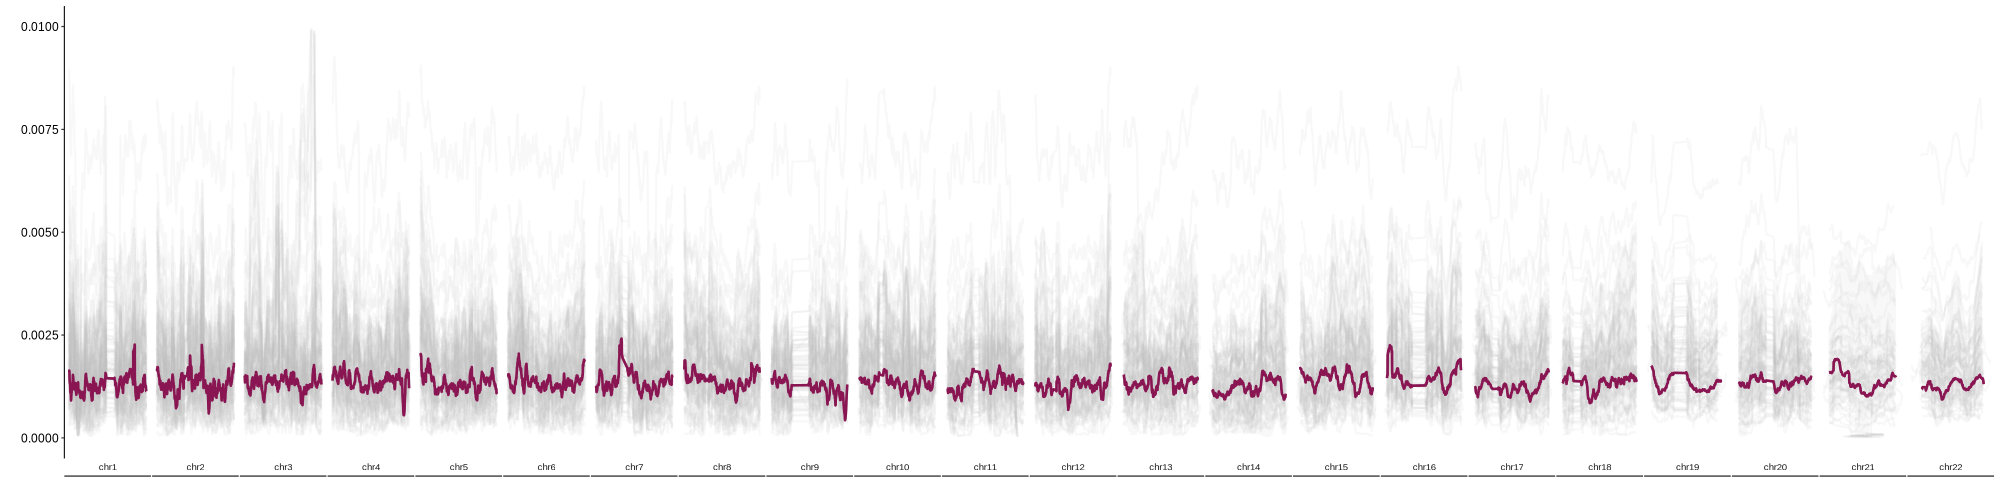

In [16]:
%%R -h 500 -w 2000

specific_species_new_world <- roll %>% 
    filter(pg_name == 'New_world_monkeys') %>%
    filter(!(species %in% c('zaza','albinasus'))) %>%
    filter(species == 'albicans') %>%
    group_by(genus,species)


plot_diversity_genome_new_world <- roll %>% 
    filter(pg_name == 'New_world_monkeys') %>%
    filter(!(species %in% c('zaza','albinasus'))) %>%
    group_by(genus,species) %>%
    ggplot(aes(x=pos,y=roll_pi, group = species, col = species == 'albicans')) +
    geom_line(aes(alpha = ifelse(species == 'albicans', 1, 0.0005)), size = 1) +
    geom_line(data = specific_species_new_world,aes(x=pos,y=roll_pi), size = 1.2) +
    ggpubr::theme_pubr(legend = 'none') +
    scale_colour_manual(values = c('grey','#891652'))+
    facet_wrap(chr~., scales = 'free_x', nrow=1, strip.position = 'bottom')+
    xlab('')+
    ylab('') +
    ylim(0,0.01)+
    theme(axis.text.x=element_blank(), #remove x axis labels
        axis.ticks.x=element_blank(),
        panel.spacing=unit(.08,"lines"),
        strip.background = element_blank())

plot_diversity_genome_new_world

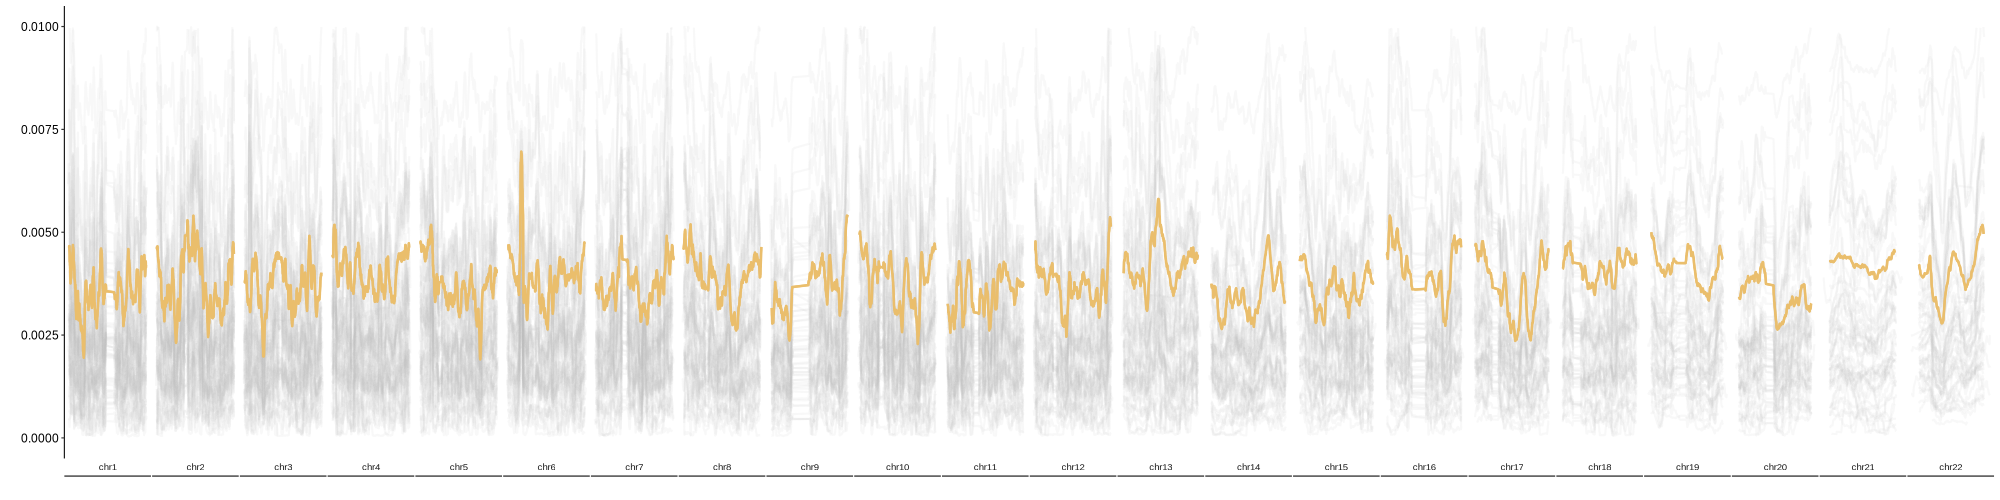

In [17]:
%%R -h 500 -w 2000

specific_species_old_world <- roll %>% 
    filter(pg_name == 'Old_world_monkeys') %>%
    filter(!(species %in% c('zaza','albinasus'))) %>%
    filter(species == 'fascicularis') %>%
    group_by(genus,species)


plot_diversity_genome_old_world <- roll %>% 
    filter(pg_name == 'Old_world_monkeys') %>%
    filter(!(species %in% c('zaza','albinasus'))) %>%
    group_by(genus,species) %>%
    ggplot(aes(x=pos,y=roll_pi, group = species, col = species == 'fascicularis')) +
    geom_line(aes(alpha = ifelse(species == 'fascicularis', 1, 0.0005)), size = 1) +
    geom_line(data = specific_species_old_world,aes(x=pos,y=roll_pi), size = 1.2) +
    ggpubr::theme_pubr(legend = 'none') +
    scale_colour_manual(values = c('grey','#eabe6c'))+
    facet_wrap(chr~., scales = 'free_x', nrow=1, strip.position = 'bottom')+
    xlab('')+
    ylab('') +
    ylim(0,0.01)+
    theme(axis.text.x=element_blank(), #remove x axis labels
        axis.ticks.x=element_blank(),
        panel.spacing=unit(.08,"lines"),
        strip.background = element_blank())

plot_diversity_genome_old_world

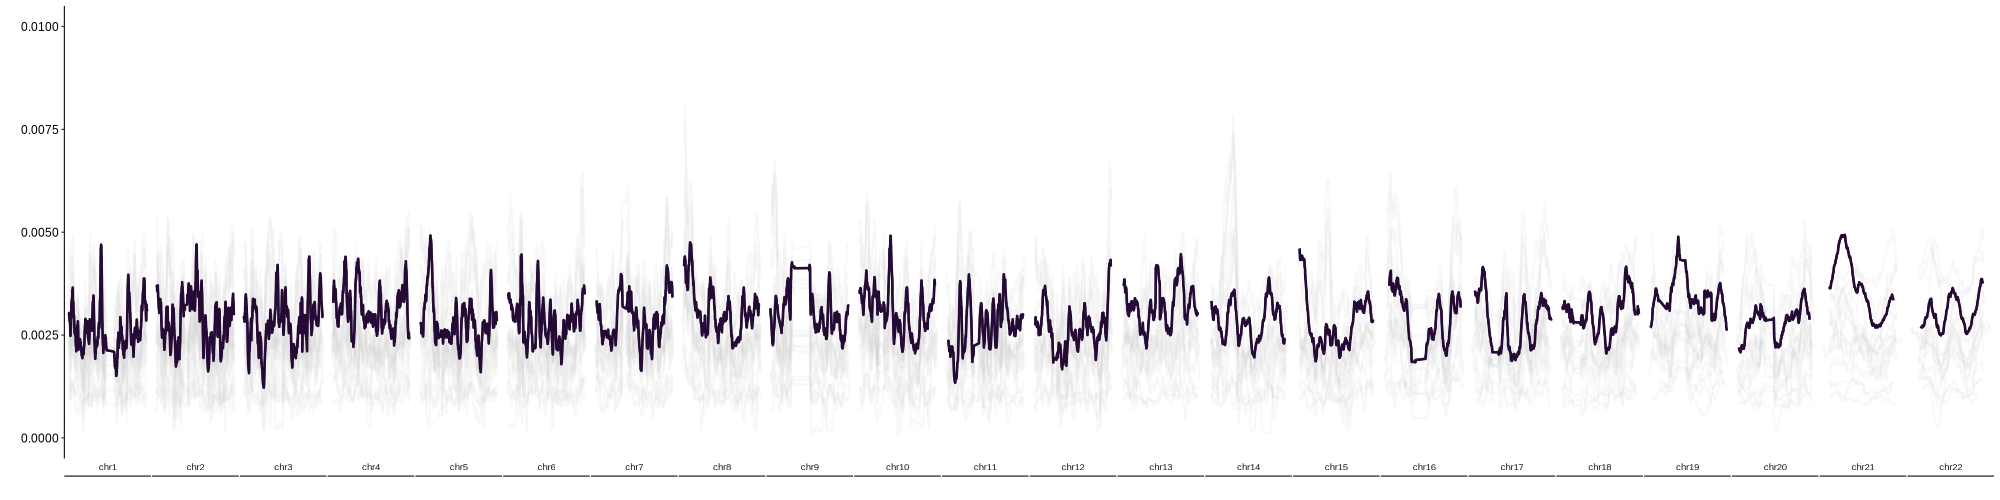

In [18]:
%%R -h 500 -w 2000

specific_species_apes <- roll %>% 
    filter(pg_name == 'Great_apes') %>%
    filter(!(species %in% c('zaza','albinasus'))) %>%
    filter(species == 'abelii') %>%
    group_by(genus,species)


plot_diversity_genome_apes <- roll %>% 
    filter(pg_name == 'Great_apes') %>%
    filter(!(species %in% c('zaza','albinasus'))) %>%
    group_by(genus,species) %>%
    ggplot(aes(x=pos,y=roll_pi, group = species, col = species == 'abelii')) +
    geom_line(aes(alpha = ifelse(species == 'abelii', 1, 0.005)), size = 1) +
    geom_line(data = specific_species_apes,aes(x=pos,y=roll_pi), size = 1.2) +
    ggpubr::theme_pubr(legend = 'none') +
    scale_colour_manual(values = c('grey','#240a34'))+
    facet_wrap(chr~., scales = 'free_x', nrow=1, strip.position = 'bottom')+
    xlab('')+
    ylab('') +
    ylim(0,0.01)+
    theme(axis.text.x=element_blank(), #remove x axis labels
        axis.ticks.x=element_blank(),
        panel.spacing=unit(.08,"lines"),
        strip.background = element_blank())

plot_diversity_genome_apes

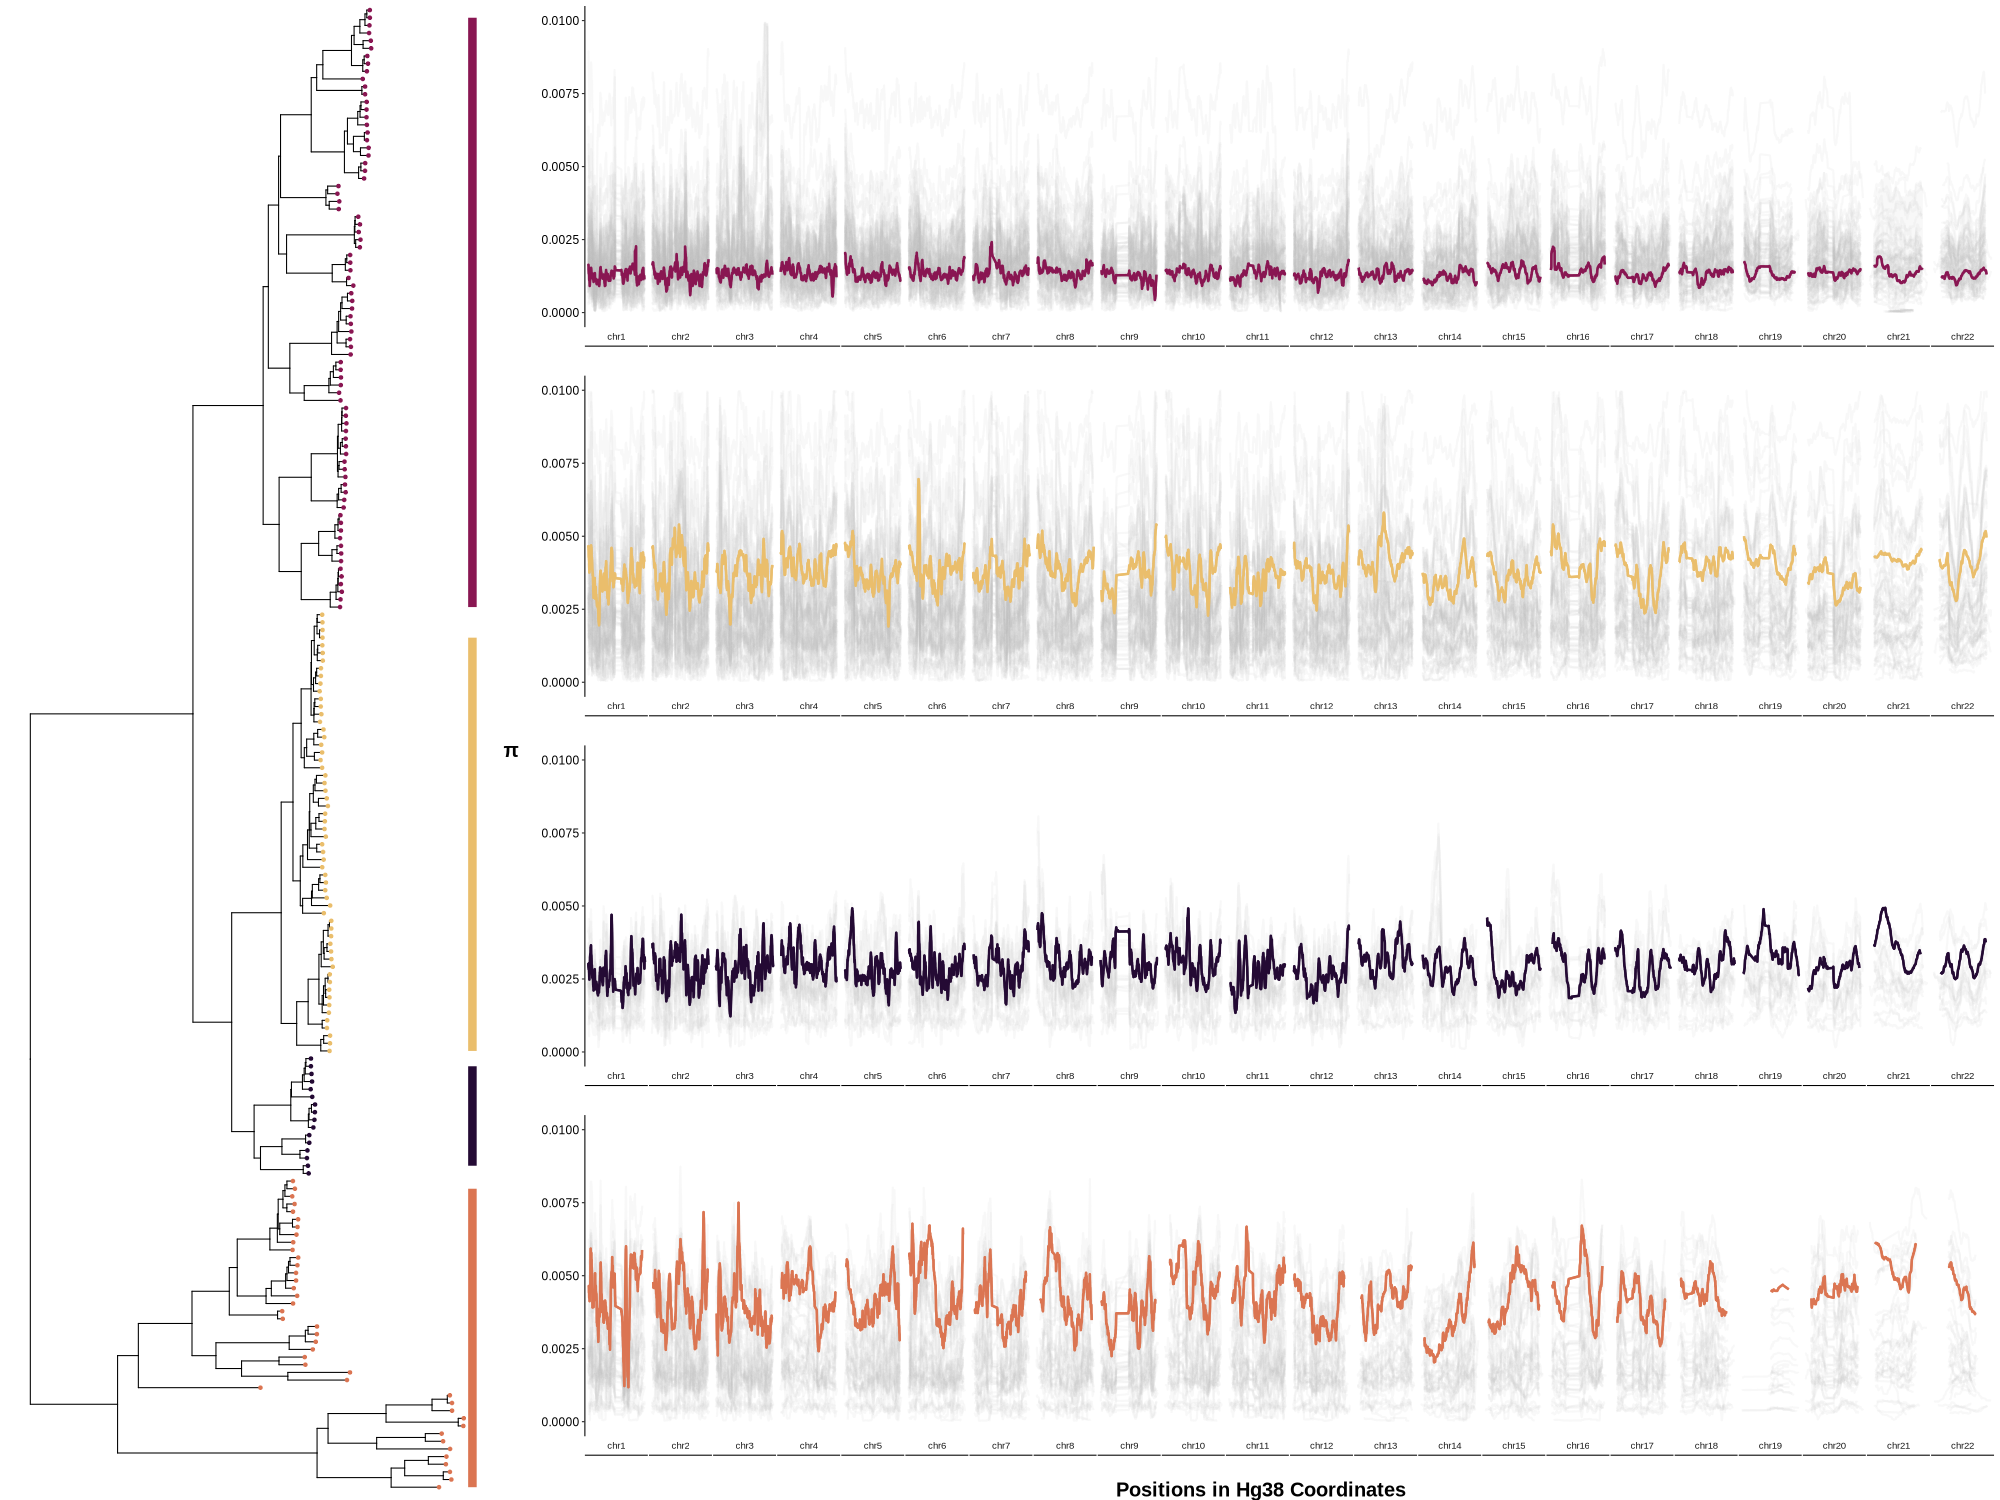

In [28]:
%%R -h 1500 -w 2000



sub_figure <- ggarrange(plot_diversity_genome_new_world,
                      plot_diversity_genome_old_world,
                      plot_diversity_genome_apes,
                      plot_diversity_genome_prosimians,
                      ncol=1,nrow=4, align = 'v')
sub_figure <- annotate_figure(sub_figure,
                bottom = text_grob("Positions in Hg38 Coordinates", color = "black", face = "bold", size = 20),
                left = text_grob("π", color = "black",face = "bold", size = 20))


figure <- ggarrange(plot_tree2, sub_figure, 
          widths = c(1,3),
          ncol=2)
figure

In [31]:
%%R
ggsave("figures_for_article/pi_across_all_species_and_phylogenetic_tree.png",width = 17, height = 10, figure, dpi = 500)
ggsave("figures_for_article/pi_across_all_species_and_phylogenetic_tree.svg",width = 17, height = 10, figure, dpi = 500)